In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import os
import json

In [48]:
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/Desi_data/artist_data.json
./data/Desi_data/album_data.json
./data/Desi_data/StreamingHistory0.json
./data/Desi_data/processed_filtered_dataset.json
./data/Desi_data/top_artists.json
./data/Desi_data/listened_filtered_raw.pkl
./data/Desi_data/listened_raw.pkl
./data/Desi_data/track_data.json
./data/Kaggle_data/artist_data.json
./data/Kaggle_data/StreamingHistory0.json
./data/Kaggle_data/processed_filtered_dataset.json
./data/Kaggle_data/top_artists.json
./data/Kaggle_data/listened_filtered_raw.pkl
./data/Kaggle_data/listened_raw.pkl
./data/Kaggle_data/track_data.json
./data/Jonatan_data/artist_data.json
./data/Jonatan_data/StreamingHistory0.json
./data/Jonatan_data/processed_filtered_dataset.json
./data/Jonatan_data/top_artists.json
./data/Jonatan_data/listened_filtered_raw.pkl
./data/Jonatan_data/listened_raw.pkl
./data/Jonatan_data/track_data.json


In [49]:
folder = "./data/Kaggle_data/"

In [50]:
# Create URL to JSON file (alternatively this can be a filepath)
json_file = folder + "StreamingHistory0.json"

# Load the first sheet of the JSON file into a data frame
df = pd.read_json(json_file, orient='columns')

# View the first ten rows
df.head(10)

,endTime,artistName,trackName,msPlayed
0,2019-02-13 06:25,Ludwig van Beethoven,"Piano Sonata No. 17 In D Minor, Op. 31, No. 2 ...",5827
1,2019-02-13 06:26,Ludwig van Beethoven,"Piano Sonata No. 17 In D Minor, Op. 31, No. 2 ...",2069
2,2019-02-13 06:26,Danney Alkana,"Beethoven: ""Symphony No. Five"" Complete",6574
3,2019-02-13 06:26,Ludwig van Beethoven,"Piano Sonata No. 14 in C-Sharp Minor, Op. 27 N...",12975
4,2019-02-13 06:30,Ludwig van Beethoven,"Beethoven: Symphony No. 7 in A Major, Op. 92: ...",237475
5,2019-02-13 06:33,Antonín Dvořák,"Songs My Mother Taught Me from Gypsy Melodie, ...",175731
6,2019-02-13 07:34,Frederick Delius,"Two Aquarelles (1987 Remaster): II. Gaily, but...",49225
7,2019-02-15 05:18,Depeche Mode,Enjoy the Silence - Single Mix,255246
8,2019-02-15 05:23,Depeche Mode,Just Can't Get Enough (Live in Hammersmith) - ...,335202
9,2019-02-15 05:26,Depeche Mode,Personal Jesus - Original Seven Inch Version,166488


In [51]:
print(len(df))

3573


In [52]:
# Some stats
print(df["msPlayed"].mean(), df["msPlayed"].min(), df["msPlayed"].max())

70272.04729918836 0 644238


In [53]:
## filter tracks by msPlayed
threshold = 10000  # 10 seconds
fully_listened = df.loc[df['msPlayed'] >= threshold] 
skipped = df.loc[df['msPlayed'] < threshold] 

In [54]:
# ratio skipped and fuly listened
print("Fully listened to %.2f%% \nTotal number of tracks %d" % (len(fully_listened)/len(df)*100, len(fully_listened)))
print("\nSkipped to %.2f%% \nTotal number of tracks %d" % (len(skipped)/len(df)*100, len(skipped)))

Fully listened to 47.89% 
Total number of tracks 1711

Skipped to 52.11% 
Total number of tracks 1862


Text(0.5, 0, 'seconds')

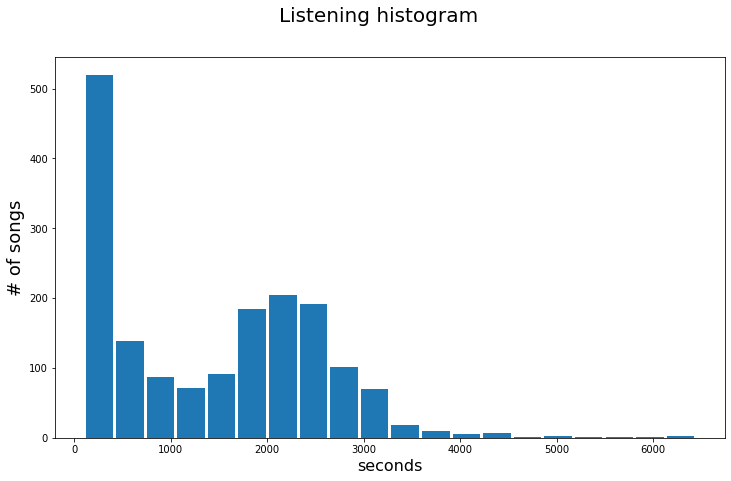

In [55]:
fig = plt.figure(figsize=(12, 7))
plt.hist(fully_listened['msPlayed']/100, bins=20,  rwidth=0.9)
fig.suptitle('Listening histogram', fontsize=20)
plt.ylabel('# of songs', fontsize=18)
plt.xlabel('seconds', fontsize=16)

# Spotify API: Extract data and features

In [56]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [57]:
client_id = "b9dbb97e8d404c7ca611adc9aa7814c6"
client_secret = "49de3614d07a4ac5bab51f4c3e836c47"
credentials = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
# token = credentials.get_access_token()

spotify = spotipy.Spotify(auth_manager=credentials)

In [58]:
# Extract data functions

def get_track_details(row):
    try:
        return spotify.search(q="track:" + row.trackName[:40] + " artist:" + row.artistName, limit=1, type="track")
    except ReadTimeout as e:
        print(row)
        return None
        

def get_track_features(track_id):
    if track_id is not None:
        for i in range(1, 6):  # max 5 retries
            try:
                return spotify.audio_features(track_id)
            except:
                print("Couldn't fetch data for %s at try %d" % (track_id, i))
                pass
    return None

def extract_album_id(track_details):
    try:
        return track_details["tracks"]["items"][0]["album"]["id"]
    except IndexError as e:
        return None
    
def get_track_album_data(album_id):
    try:
        return spotify.album(album_id)
    except IndexError as e:
        return None

def get_track_genre_by_artist(artist_details):
    try:
        return artist_details["genres"]
    except IndexError as e:
        return None
    
def get_artist_id(track_details):
    try:
        return track_details["tracks"]["items"][0]["album"]["artists"][0]["id"]
    except IndexError as e:
        return None
    
def get_artist_data(artist_id):
    try:
        return spotify.artist(artist_id)
    except ReadTimeout as e:
        print(artist_id)
        return None

def get_track_id(track_details):
    try:
        return track_details['tracks']['items'][0]['id']
    except:
        return None
    
def get_track_duration(track_details):
    try:
        return track_details['tracks']['items'][0]['duration_ms']
    except:
        return None

def get_track_popularity(track_details):
    try:
        return track_details['tracks']['items'][0]['popularity']
    except:
        return None

In [59]:
unique = fully_listened.drop_duplicates(subset=['trackName'])
track_data = {}

In [60]:
for i, row in unique.iterrows():
    track_data[row.trackName] = get_track_details(row)

In [61]:
fully_listened["trackDetails"] = fully_listened.trackName.apply(lambda x: track_data[x])
fully_listened.head()

/home/iivanova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,endTime,artistName,trackName,msPlayed,trackDetails
3,2019-02-13 06:26,Ludwig van Beethoven,"Piano Sonata No. 14 in C-Sharp Minor, Op. 27 N...",12975,{'tracks': {'href': 'https://api.spotify.com/v...
4,2019-02-13 06:30,Ludwig van Beethoven,"Beethoven: Symphony No. 7 in A Major, Op. 92: ...",237475,{'tracks': {'href': 'https://api.spotify.com/v...
5,2019-02-13 06:33,Antonín Dvořák,"Songs My Mother Taught Me from Gypsy Melodie, ...",175731,{'tracks': {'href': 'https://api.spotify.com/v...
6,2019-02-13 07:34,Frederick Delius,"Two Aquarelles (1987 Remaster): II. Gaily, but...",49225,{'tracks': {'href': 'https://api.spotify.com/v...
7,2019-02-15 05:18,Depeche Mode,Enjoy the Silence - Single Mix,255246,{'tracks': {'href': 'https://api.spotify.com/v...


In [62]:
fully_listened.trackDetails.head()

3    {'tracks': {'href': 'https://api.spotify.com/v...
4    {'tracks': {'href': 'https://api.spotify.com/v...
5    {'tracks': {'href': 'https://api.spotify.com/v...
6    {'tracks': {'href': 'https://api.spotify.com/v...
7    {'tracks': {'href': 'https://api.spotify.com/v...
Name: trackDetails, dtype: object

In [63]:
fully_listened["trackId"] = fully_listened["trackDetails"].apply(get_track_id)

/home/iivanova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [64]:
fully_listened["trackDuration"] = fully_listened["trackDetails"].apply(get_track_duration)

/home/iivanova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [65]:
fully_listened["trackPopularity"] = fully_listened["trackDetails"].apply(get_track_popularity)

/home/iivanova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [66]:
fully_listened["trackAlbum"] = fully_listened["trackDetails"].apply(extract_album_id)

/home/iivanova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [67]:
fully_listened["trackArtistId"] = fully_listened["trackDetails"].apply(get_artist_id)

/home/iivanova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [68]:
unique_track_ids = fully_listened.trackId.unique()

In [69]:
track_details = {}
for track_id in unique_track_ids:
    track_details[track_id] = get_track_features(track_id)

In [70]:
fully_listened["trackFeatures"] = fully_listened["trackId"].apply(lambda x: track_details[x])

/home/iivanova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [71]:
fully_listened.head()

,endTime,artistName,trackName,msPlayed,trackDetails,trackId,trackDuration,trackPopularity,trackAlbum,trackArtistId,trackFeatures
3,2019-02-13 06:26,Ludwig van Beethoven,"Piano Sonata No. 14 in C-Sharp Minor, Op. 27 N...",12975,{'tracks': {'href': 'https://api.spotify.com/v...,5x4JURaUqDOmsW8cQWfKR7,326980.0,0.0,1F9IYEDYiv5hu3305CYYiR,0LyfQWJT6nXafLPZqxe9Of,"[{'danceability': 0.221, 'energy': 0.0681, 'ke..."
4,2019-02-13 06:30,Ludwig van Beethoven,"Beethoven: Symphony No. 7 in A Major, Op. 92: ...",237475,{'tracks': {'href': 'https://api.spotify.com/v...,48LZLWlKuyrcp4t0iQJeqd,485367.0,40.0,5fpZpfJBKmG82qAvPRwZK8,2wOqMjp9TyABvtHdOSOTUS,"[{'danceability': 0.423, 'energy': 0.344, 'key..."
5,2019-02-13 06:33,Antonín Dvořák,"Songs My Mother Taught Me from Gypsy Melodie, ...",175731,{'tracks': {'href': 'https://api.spotify.com/v...,2oGjnkGZgpU3j70zbtJgzV,136160.0,0.0,7uQVkMjnWDvV9JEcVine7k,6n7nd5iceYpXVwcx8VPpxF,"[{'danceability': 0.266, 'energy': 0.122, 'key..."
6,2019-02-13 07:34,Frederick Delius,"Two Aquarelles (1987 Remaster): II. Gaily, but...",49225,{'tracks': {'href': 'https://api.spotify.com/v...,4PwywCngJG2ykV2D0HG368,124026.0,12.0,5kTtD1xA5yYPrwjEYWk5uy,0LyfQWJT6nXafLPZqxe9Of,"[{'danceability': 0.194, 'energy': 0.132, 'key..."
7,2019-02-15 05:18,Depeche Mode,Enjoy the Silence - Single Mix,255246,{'tracks': {'href': 'https://api.spotify.com/v...,1YwNlWLf8auhazSQUDQLFU,257333.0,67.0,13OoJ5Y23cdo8CDAiQwznb,762310PdDnwsDxAQxzQkfX,"[{'danceability': 0.641, 'energy': 0.812, 'key..."


In [72]:
fully_listened.to_pickle(folder + "listened_raw.pkl")
# fully_listened = pd.read_pickle("./data/Desi_data/listened_raw.pkl")

In [73]:
# clean-up None values
filtered = fully_listened.loc[fully_listened["trackId"].notna()]
print("Just cleaned up %d tracks" % (fully_listened.shape[0] - filtered.shape[0]))

Just cleaned up 115 tracks


In [74]:
filtered.drop("trackDetails", axis=1, inplace=True)
filtered.head()

/home/iivanova/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,endTime,artistName,trackName,msPlayed,trackId,trackDuration,trackPopularity,trackAlbum,trackArtistId,trackFeatures
3,2019-02-13 06:26,Ludwig van Beethoven,"Piano Sonata No. 14 in C-Sharp Minor, Op. 27 N...",12975,5x4JURaUqDOmsW8cQWfKR7,326980.0,0.0,1F9IYEDYiv5hu3305CYYiR,0LyfQWJT6nXafLPZqxe9Of,"[{'danceability': 0.221, 'energy': 0.0681, 'ke..."
4,2019-02-13 06:30,Ludwig van Beethoven,"Beethoven: Symphony No. 7 in A Major, Op. 92: ...",237475,48LZLWlKuyrcp4t0iQJeqd,485367.0,40.0,5fpZpfJBKmG82qAvPRwZK8,2wOqMjp9TyABvtHdOSOTUS,"[{'danceability': 0.423, 'energy': 0.344, 'key..."
5,2019-02-13 06:33,Antonín Dvořák,"Songs My Mother Taught Me from Gypsy Melodie, ...",175731,2oGjnkGZgpU3j70zbtJgzV,136160.0,0.0,7uQVkMjnWDvV9JEcVine7k,6n7nd5iceYpXVwcx8VPpxF,"[{'danceability': 0.266, 'energy': 0.122, 'key..."
6,2019-02-13 07:34,Frederick Delius,"Two Aquarelles (1987 Remaster): II. Gaily, but...",49225,4PwywCngJG2ykV2D0HG368,124026.0,12.0,5kTtD1xA5yYPrwjEYWk5uy,0LyfQWJT6nXafLPZqxe9Of,"[{'danceability': 0.194, 'energy': 0.132, 'key..."
7,2019-02-15 05:18,Depeche Mode,Enjoy the Silence - Single Mix,255246,1YwNlWLf8auhazSQUDQLFU,257333.0,67.0,13OoJ5Y23cdo8CDAiQwznb,762310PdDnwsDxAQxzQkfX,"[{'danceability': 0.641, 'energy': 0.812, 'key..."


In [75]:
filtered.trackFeatures.head()

3    [{'danceability': 0.221, 'energy': 0.0681, 'ke...
4    [{'danceability': 0.423, 'energy': 0.344, 'key...
5    [{'danceability': 0.266, 'energy': 0.122, 'key...
6    [{'danceability': 0.194, 'energy': 0.132, 'key...
7    [{'danceability': 0.641, 'energy': 0.812, 'key...
Name: trackFeatures, dtype: object

In [76]:
filtered.to_pickle(folder + "listened_filtered_raw.pkl")
# filtered = pd.read_pickle("./data/Desi_data/listened_filtered_raw.pkl")

In [77]:
uniques_artist_ids = filtered.trackArtistId.unique()
artist_details = {}
for artist in uniques_artist_ids:
    artist_details[artist] = get_artist_data(artist)

In [78]:
# Extract Artist Data
artist_data = {}
for i, row in filtered.iterrows():
    artist_id = row["trackArtistId"]
    if artist_id not in artist_data:
        artist_data[artist_id] = {"name": artist_details[artist_id]["name"],
                                  "genres": artist_details[artist_id]["genres"],
                                  "popularity": artist_details[artist_id]["popularity"],
                                  "followers": artist_details[artist_id]["followers"]["total"]}

In [79]:
with open(folder + "artist_data.json", "w") as f:
    json.dump(artist_data, f, indent='\t', separators=(',', ': '))

In [80]:
# # Extract Album Data
# album_data = {}
# for i, row in filtered.iterrows():
#     album_id = row["trackAlbum"]
#     if album_id not in album_data:
#         album_details = get_track_album_data(album_id)
#         album_data[album_id] = {"name": album_details["name"],
#                                 "genres": album_details["genres"],
#                                 "popularity": album_details["popularity"],
#                                 "label": album_details["label"],
#                                 "total_tracks": album_details["total_tracks"],
#                                 "artists": [a["name"] for a in album_details["artists"]],
#                                 "artists_id": [a["id"] for a in album_details["artists"]]}

In [81]:
# with open(folder + "album_data.json", "w") as f:
#     json.dump(album_data, f, indent='\t', separators=(',', ': '))

In [82]:
# Extract only track features
track_features = {}
for i, row in filtered.iterrows():
    features = row["trackFeatures"]
    track_features[row["trackId"]] = {"name": row["trackName"], 
                                      "track_features": features[0],
#                                       "album_genres": album_data[row["trackAlbum"]]["genres"],
                                      "artist_genres": artist_data[row["trackArtistId"]]["genres"]}

In [83]:
with open(folder + "track_data.json", "w") as f:
    json.dump(track_features, f, indent='\t', separators=(',', ': '))

In [84]:
filtered["date"] = filtered.endTime.apply(lambda x: x.split(" ")[0])

/home/iivanova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [85]:
dataset = {}
for i, row in filtered.iterrows():
    data = dataset.get(row["date"], [])
    data.append({"date": row["date"],
                 "artist": row["artistName"],
                 "track_duration": row["trackDuration"],
                 "artist_id": row["trackArtistId"],
    })
    dataset[row["date"]] = data

In [86]:
full_dataset = {}
empty_artist = [{"name": "", "popularity": 0, "id": "", "artist_duration": 0, "artist_genres": []}]
all_artists = {}

for date, data in dataset.items():
    temp = {}
    for log in data:
        temptemp = temp.get(log["artist"], {"duration": 0, "id":""})
        temptemp["duration"] += log["track_duration"]
        temptemp["id"] = log["artist_id"]
        temp[log["artist"]] = temptemp
        
    total = sum(list([data["duration"] for artist, data in temp.items()]))
    artists = list([{"name": artist,
                     "popularity": artist_data[data["id"]]["popularity"],
                     "id": data["id"],
                     "artist_duration": data["duration"],
                     "artist_genres": artist_data[data["id"]]["genres"],
                    } for artist, data in temp.items()])
    artists = sorted(artists, key=lambda x: x["artist_duration"], reverse=True)
    
    for i, artist in enumerate(artists):
        artist["rank"] = i+1
    
    for artist in artists:
        if artist["name"] not in all_artists:
            all_artists[artist["name"]] = {
                "name": artist["name"],
                "popularity": artist["popularity"],
                "id": artist["id"],
                "artist_duration": artist["artist_duration"],
                "artist_genres": artist["artist_genres"],
                
            }
            continue
        prev = all_artists[artist["name"]]
        prev["artist_duration"] += artist["artist_duration"]
        all_artists[artist["name"]] = prev
      
    if (20 - len(artists) > 0):
        artists.extend(empty_artist * (20 - len(artists)))
    
    full_dataset[date] = {
        "date": date,
        "full_day_duration": total,
        "artists": artists,
    }

In [87]:
from datetime import date, timedelta
all_days = sorted(full_dataset.keys())

start = all_days[0].split("-")
end = all_days[-1].split("-")

start = date(int(start[0]), int(start[1]), int(start[2]))
end = date(int(end[0]), int(end[1]), int(end[2]))

In [88]:
all_dates = pd.date_range(start, end - timedelta(days=1), freq='d')

In [89]:
for d in all_dates:
    if d.strftime("%Y-%m-%d") not in full_dataset:
        full_dataset[d.strftime("%Y-%m-%d")] = {
            "date": d.strftime("%Y-%m-%d"),
            "full_day_duration": 0,
            "artists": []}

In [90]:
from collections import OrderedDict
full_dataset = OrderedDict(sorted(full_dataset.items()))

In [91]:
with open(folder + "processed_filtered_dataset.json", "w") as f:
    json.dump(full_dataset, f, indent='\t', separators=(',', ': '))

In [92]:
sorted_all_artists = sorted(all_artists.values(), key=lambda x: x["artist_duration"], reverse=True)
for i, artist in enumerate(sorted_all_artists):
    artist["rank"] = i+1
    
with open(folder + "top_artists.json", "w") as f:
    json.dump(sorted_all_artists, f, indent='\t', separators=(',', ': '))